# SQS elastic constants

This notebook demonstrates the functionality of job classes designed to calculate chemistry-dependent elastic data by averaging over one or more special-quasirandom structures.

In [1]:
from pyiron import Project
import pyiron_contrib
from elastic import ElasticMatrixJob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pr = Project('scratch2')
#pr.remove_jobs(recursive=True)

# Setup reference jobs

The input to these SQS elastic job classes is quite minimal, rather run parameters are passed in in the form of reference jobs.

Of special importance are the `SQSJob` type reference, which handles the generation of special quasirandom structures, and `ElasticMatrixJob`, which computes the elastic constants. Thankfully, these jobs already existed, so the development of the new SQS elastic jobs was just a matter of stringing them together. 

An advantage of this setup is that any new improvements to the functionality of these underlying jobs is included in the SQS elastic jobs without having to modify SQS elastic code specifically, since they appear simply as references. However, the flip side of the coin is that the functionality of these jobs was not exhaustively tested. Results are very reasonable for the FCC Al system tested, but keep your physicist hat on when running the code and ensure that your results are coming out sensibly.

The final and most basic reference is the model which will interpret atomic positions to produce forces and energies. Here we'll use Lammps, but, if you have a lot of processor power lying around, there should be no barrier to using a quantum mechanical code like Vasp instead.

Here, we'll scale a lot of the input parameters way back so the calculations run faster.

In [3]:
lammps = pr.create_job(pr.job_type.Lammps, 'hr')
lammps.structure = pr.create_ase_bulk('Cu', cubic=True).repeat(5)
lammps.structure[:3] = 'Ni'

In [4]:
lammps.list_potentials()

['FeCuNi_eam_alloy',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr2',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr1',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 'EAM_Dynamo_BonnyPasianotCastin_2009_FeCuNi__MO_469343973171_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EMT_Asap_Standard_JacobsenStoltzeNorskov_1996_AlAgAuCuNiPdPt__MO_115316750986_001']

In [5]:
lammps.potential = lammps.list_potentials()[1]
lammps.potential

,Config,Filename,Model,Name,Species
170,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"
385,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"


In [6]:
sqs = pr.create_job(pr.job_type.SQSJob, 'sr')
sqs.input.iterations = 100
sqs.input.weights = None
sqs.input.n_output_structures = 2 

In [7]:
elastic = pr.create_job(ElasticMatrixJob, 'er')
elastic.input['num_of_points'] = 3
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = False
elastic.input['sqrt_eta'] = False

# Option 2: Scan various compositions

Alternatively, we might want to look for chemical trends across multiple different compositions. This is also possible. 

In [8]:
sqs_elastic_ref = pr.create_job(pr.job_type.SQSElasticConstants, 'se')
sqs_elastic_ref.ref_ham = lammps
sqs_elastic_ref.ref_sqs = sqs
sqs_elastic_ref.ref_elastic = elastic

job = sqs_elastic_ref.create_job(pr.job_type.SQSElasticConstantsList, 'scan')
job.input.compositions = [
    {'Cu': 1., 'Ni': 0.},
    {'Cu': 0.95, 'Ni': 0.05},
    {'Cu': 0.90, 'Ni': 0.10},
    {'Cu': 0.85, 'Ni': 0.15},
    {'Cu': 0.80, 'Ni': 0.20},
    {'Cu': 0.70, 'Ni': 0.30},
    {'Cu': 0.60, 'Ni': 0.40},
    {'Cu': 0.50, 'Ni': 0.50},
    {'Cu': 0.40, 'Ni': 0.60},
    {'Cu': 0.30, 'Ni': 0.70},
    {'Cu': 0.20, 'Ni': 0.80},
    {'Cu': 0.10, 'Ni': 0.90},
    {'Cu': 0., 'Ni': 1.}
]
job.run()

The job se_ham_ref was saved and received the ID: 1867
The job se_sqs_ref was saved and received the ID: 1868
The job se_el_job was saved and received the ID: 1869
The job scan was saved and received the ID: 1870
The job Cu10_Ni00_ham_ref was saved and received the ID: 1871
The job Cu10_Ni00_sqs_ref was saved and received the ID: 1872
The job Cu10_Ni00_el_job was saved and received the ID: 1873
The job Cu10_Ni00 was saved and received the ID: 1874
The job Cu10_Ni00_sqs was saved and received the ID: 1875
Threads used: 1
The job Cu10_Ni00_min was saved and received the ID: 1876
The job struct_0 was saved and received the ID: 1877
The job Cu10_Ni00_elastic was saved and received the ID: 1878
The job struct_0 was saved and received the ID: 1879
The job s_e_0 was saved and received the ID: 1880
The job s_01_e_m0_00500 was saved and received the ID: 1881
The job s_01_e_0_00500 was saved and received the ID: 1882
The job s_08_e_m0_00500 was saved and received the ID: 1883
The job s_08_e_0_00

Threads used: 1
The job Cu085_Ni015_min was saved and received the ID: 2005
The job struct_0 was saved and received the ID: 2006
The job Cu085_Ni015_elastic was saved and received the ID: 2007
The job struct_0 was saved and received the ID: 2008
The job s_e_0 was saved and received the ID: 2009
The job s_02_e_m0_00500 was saved and received the ID: 2010
The job s_02_e_0_00500 was saved and received the ID: 2011
The job s_03_e_m0_00500 was saved and received the ID: 2012
The job s_03_e_0_00500 was saved and received the ID: 2013
The job s_04_e_m0_00500 was saved and received the ID: 2014
The job s_04_e_0_00500 was saved and received the ID: 2015
The job s_05_e_m0_00500 was saved and received the ID: 2016
The job s_05_e_0_00500 was saved and received the ID: 2017
The job s_06_e_m0_00500 was saved and received the ID: 2018
The job s_06_e_0_00500 was saved and received the ID: 2019
The job s_07_e_m0_00500 was saved and received the ID: 2020
The job s_07_e_0_00500 was saved and received the

The job s_13_e_0_00500 was saved and received the ID: 2143
The job s_14_e_m0_00500 was saved and received the ID: 2144
The job s_14_e_0_00500 was saved and received the ID: 2145
The job s_15_e_m0_00500 was saved and received the ID: 2146
The job s_15_e_0_00500 was saved and received the ID: 2147
The job s_16_e_m0_00500 was saved and received the ID: 2148
The job s_16_e_0_00500 was saved and received the ID: 2149
The job s_17_e_m0_00500 was saved and received the ID: 2150
The job s_17_e_0_00500 was saved and received the ID: 2151
The job s_18_e_m0_00500 was saved and received the ID: 2152
The job s_18_e_0_00500 was saved and received the ID: 2153
The job s_19_e_m0_00500 was saved and received the ID: 2154
The job s_19_e_0_00500 was saved and received the ID: 2155
The job s_20_e_m0_00500 was saved and received the ID: 2156
The job s_20_e_0_00500 was saved and received the ID: 2157
The job s_21_e_m0_00500 was saved and received the ID: 2158
The job s_21_e_0_00500 was saved and received th

The job struct_0 was saved and received the ID: 2281
The job Cu04_Ni06_elastic was saved and received the ID: 2282
The job struct_0 was saved and received the ID: 2283
The job s_e_0 was saved and received the ID: 2284
The job s_02_e_m0_00500 was saved and received the ID: 2285
The job s_02_e_0_00500 was saved and received the ID: 2286
The job s_03_e_m0_00500 was saved and received the ID: 2287
The job s_03_e_0_00500 was saved and received the ID: 2288
The job s_04_e_m0_00500 was saved and received the ID: 2289
The job s_04_e_0_00500 was saved and received the ID: 2290
The job s_05_e_m0_00500 was saved and received the ID: 2291
The job s_05_e_0_00500 was saved and received the ID: 2292
The job s_06_e_m0_00500 was saved and received the ID: 2293
The job s_06_e_0_00500 was saved and received the ID: 2294
The job s_07_e_m0_00500 was saved and received the ID: 2295
The job s_07_e_0_00500 was saved and received the ID: 2296
The job s_08_e_m0_00500 was saved and received the ID: 2297
The job 

The job s_14_e_0_00500 was saved and received the ID: 2420
The job s_15_e_m0_00500 was saved and received the ID: 2421
The job s_15_e_0_00500 was saved and received the ID: 2422
The job s_16_e_m0_00500 was saved and received the ID: 2423
The job s_16_e_0_00500 was saved and received the ID: 2424
The job s_17_e_m0_00500 was saved and received the ID: 2425
The job s_17_e_0_00500 was saved and received the ID: 2426
The job s_18_e_m0_00500 was saved and received the ID: 2427
The job s_18_e_0_00500 was saved and received the ID: 2428
The job s_19_e_m0_00500 was saved and received the ID: 2429
The job s_19_e_0_00500 was saved and received the ID: 2430
The job s_20_e_m0_00500 was saved and received the ID: 2431
The job s_20_e_0_00500 was saved and received the ID: 2432
The job s_21_e_m0_00500 was saved and received the ID: 2433
The job s_21_e_0_00500 was saved and received the ID: 2434
The job s_22_e_m0_00500 was saved and received the ID: 2435
The job s_22_e_0_00500 was saved and received th

2020-11-06 11:16:35,387 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,393 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,399 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 11:16:35,550 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,556 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,562 - pyiron_log - WARNING - Job 'Cu095_Ni005_el_job' does not exist and cannot be loaded
2020-11-06 11:16:35,714 - pyiron_log - WARNING - Job 'Cu09_Ni01_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,720 - pyiron_log - WARNING - Job 'Cu09_Ni01_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:35,726 - pyiron_log - WARNING - Job 'Cu09_Ni01_el_job' does not exist and cannot be loaded
2020-11-06 11:16

2020-11-06 11:16:39,692 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:39,697 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 11:16:40,085 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:40,090 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:40,096 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 11:16:40,246 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:40,251 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:40,257 - pyiron_log - WARNING - Job 'Cu095_Ni005_el_job' does not exist and cannot be loaded
2020-11-06 11:16:40,407 - pyiron_log - WARNING - Job 'Cu09_Ni01_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16

2020-11-06 11:16:44,209 - pyiron_log - WARNING - Job 'Cu01_Ni09_el_job' does not exist and cannot be loaded
2020-11-06 11:16:44,359 - pyiron_log - WARNING - Job 'Cu00_Ni10_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:44,364 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:44,370 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 11:16:44,756 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:44,762 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:44,768 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 11:16:44,918 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:44,924 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:4

2020-11-06 11:16:48,864 - pyiron_log - WARNING - Job 'Cu01_Ni09_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:48,870 - pyiron_log - WARNING - Job 'Cu01_Ni09_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:48,875 - pyiron_log - WARNING - Job 'Cu01_Ni09_el_job' does not exist and cannot be loaded
2020-11-06 11:16:49,025 - pyiron_log - WARNING - Job 'Cu00_Ni10_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:49,031 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:49,036 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 11:16:49,422 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 11:16:49,428 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 11:16:49,434 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 11:16:49,58

In [9]:
loaded = pr.load(job.job_name)

<AxesSubplot:xlabel='Ni Atomic fraction', ylabel='Elastic constants (GPa)'>

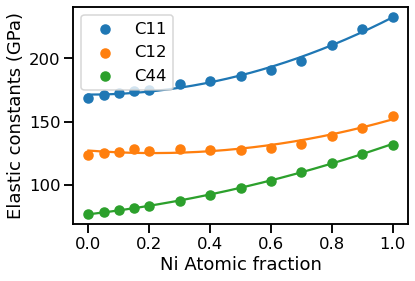

In [12]:
loaded.plot('Ni')

## DAMASK simulations
Here, we use the above fits to the data from lammps MD simulation to find the elastic constansts for a selected set of Ni concentrations. Then these values are given to DAMASK simulations to obtain the macroscopic elasto-plastic response.    

In [13]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir(cwd)

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow


In [14]:
concentrations=[0.2,0.6,1.0]

In [15]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
for i,c in enumerate(concentrations):
    os.chdir(cwd)
    simulation_folder.append('Ni-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}/tension_Ni{}.load'.format(simulation_folder[i],int(c*100)))
    path = cwd+'/'+simulation_folder[i];
    print(path)
    C11 = float(loaded.get_C11_poly('Ni')(c))
    C12 = float(loaded.get_C12_poly('Ni')(c))
    C44 = float(loaded.get_C44_poly('Ni')(c))
    print("moduli: {}, {}, {}".format(C11,C12,C44))
    print(simulation_folder[i])
    #os.chdir(simulation_folder[i])
    os.chdir(path)
#    os.system('rm *.hdf5')
    load = 'tension_Ni{}.load'.format(int(c*100))
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)
    new_geom.save(geom_name.split('.')[0])
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20
moduli: 173.77210230769833, 125.13439910987282, 83.43609635853247
Ni-20
simulation 0 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-60
moduli: 193.31169204399694, 131.55594337503655, 103.53386597830276
Ni-60
simulation 1 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-100
moduli: 232.55639574712592, 151.82563296592937, 132.42018356951888
Ni-100
simulation 2 done


## post processing of DAMASK simulations
Here, the data from damask simulations are post-process to obtain the list of strain, stress, and Von-Mises stress.

In [16]:
os.chdir(cwd)
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
#from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
#os.chdir(cwd)
for i,c in enumerate(concentrations):
    path = cwd+'/'+simulation_folder[i];
    os.chdir(path)
    #os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode

## Visualization
Here, you can find the stress-strain relation for different concentrations of Ni in a Cu-Ni alloy. The main difference lies in the elastic part. Therefore, the stain range is modified to visualize elastic deformation better.

Text(0.5, 1.0, 'Stress-Strain')

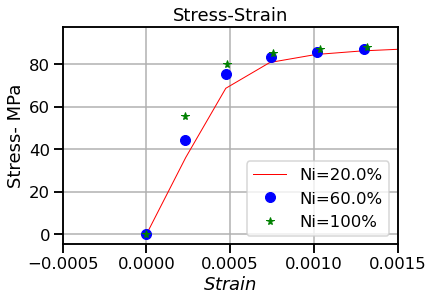

In [17]:
import matplotlib.pyplot as plt
i = 0;
#stresses[0]= eval_stress(job_file[0])
#stresses[1]= eval_stress(job_file[1])
#stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=1, label = 'Ni={}%'.format(0.2*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,markersize = 10,label = 'Ni={}%'.format(0.6*100))
plt.plot(strains[2], stresses[2], 'g', linestyle="None",marker = '*', markersize = 8 ,label = 'Ni={}%'.format(1*100))
plt.xlim(-0.0005,0.0015)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")

## VTK visualization

Import visualization modules

In [2]:
import pyvista as pv
from itkwidgets import view

Visualizing initial geometry

In [3]:
#path = cwd+'/'+simulation_folder[0]   # put the simulation number here
#filepath = path + '/' + 'test.vtr' # put correct name for the geometry file
filepath = '/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20/test.vtr'

In [6]:
mesh = pv.read(filepath)
mesh

RectilinearGrid (0x7f182c1de3a0)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	2

## Input microstructure/geometry

In [7]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Visualize stress strain distributions

In [8]:
#path = cwd+'/'+simulation_folder[0]
#filepath = path + '/' + 'test_tension_Ni20_inc20.vtr'   #put the correct name for the vtr file
filepath = '/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20/test_tension_Ni20_inc20.vtr'


In [9]:
mesh = pv.read(filepath)
mesh

RectilinearGrid (0x7f182c1dee20)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	5

In [10]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [26]:
plotter = pv.Plotter(shape=(1, 2))

In [27]:
plotter.subplot(0, 0)
plotter.add_mesh(mesh)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7fe90f4a8b80

In [ ]:
plotter.show()